In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, logit
from sklearn.linear_model import LinearRegression
import scipy.stats as sp
from statsmodels.discrete.discrete_model import MNLogit

from skimage.io import imread, imshow
import skimage.filters as filter
import skimage.feature as feature
from skimage.measure import label
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
glow='GLOW Data2.xlsx'; lbws='LBWSdata.xlsx'
main='Reduced MNIST Data'; training='/Reduced Trainging data'; testing='/Reduced Testing data'

In [2]:
def find_corner(img):
    X_tl=np.where(img.sum(axis=1)!=0)[0][0]
    Y_tl=np.where(img[X_tl]!=0)[0][0]
    Y_bl=np.where(img.sum(axis=0)!=0)[0][0]
    X_bl=np.where(img[:,Y_bl]!=0)[0][0]
    X_tr=np.where(img.sum(axis=1)!=0)[0][-1]
    Y_tr=np.where(img[X_tr]!=0)[0][-1]
    Y_br=np.where(img.sum(axis=0)!=0)[0][-1]
    X_br=np.where(img[:,Y_br]!=0)[0][-1]
    return {'X_tl':X_tl,'Y_tl':Y_tl,'X_bl':X_bl,'Y_bl':Y_bl,'X_tr':X_tr,'Y_tr':Y_tr,'X_br':X_br,'Y_br':Y_br}
def segment_sum(img,origin,dist,side):
    row_sum=img[origin-dist:origin+dist].sum(axis=1).sum()
    col_sum=img[:,origin-dist:origin+dist].sum(axis=0).sum()
    return {side+'_row_sum':row_sum,side+'_col_sum':col_sum}
def center_sum(img,originX,originY,dist):
    return img[originX-dist:originX+dist,originY-dist:originY+dist].sum()



In [3]:
def img_data(img_og):
    img=feature.canny(img_og)
    
    outp={}
    
    #functions from the data science lesson
    outp.update({'max_col':max(img.sum(axis=0))})
    outp.update({'max_row':max(img.sum(axis=1))})
    outp.update({'total_pixel':img.sum()})
    outp.update({'width':(img == True).any(axis = 0).sum()})
    outp.update({'height':(img == True).any(axis = 1).sum()})
    outp.update({'edges':label(img).max()})

    #apply some to the image before appling canny
    outp.update({'max_col_og':max(img_og.sum(axis=0))})
    outp.update({'max_row_og':max(img_og.sum(axis=1))})
    outp.update({'total_pixel_og':img_og.sum()})

    #find the top left,top right, bottom left and bottom right most pixel on an image
    corners=find_corner(img)
    outp.update({name:value for name,value in zip(corners.keys(),corners.values())})

    #create columns and count the number of white pixels in these
    top=segment_sum(img,7,3,'top')
    outp.update({name:value for name,value in zip(top.keys(),top.values())})
    middle=segment_sum(img,14,3,'mid')
    outp.update({name:value for name,value in zip(middle.keys(),middle.values())})
    bottom=segment_sum(img,21,3,'bot')
    outp.update({name:value for name,value in zip(bottom.keys(),bottom.values())})

    #same prosces for the original images
    outp.update({name:value for name,value in zip(corners.keys(),corners.values())})
    top=segment_sum(img_og,7,3,'top_og')
    outp.update({name:value for name,value in zip(top.keys(),top.values())})
    middle=segment_sum(img_og,14,3,'mid_og')
    outp.update({name:value for name,value in zip(middle.keys(),middle.values())})
    bottom=segment_sum(img_og,21,3,'bot_og')
    outp.update({name:value for name,value in zip(bottom.keys(),bottom.values())})

    #create a square of a specific radious and count the number of pixels
    outp.update({'center':center_sum(img,14,14,4)})
    outp.update({'top_left':center_sum(img,7,7,4)})
    outp.update({'bot_left':center_sum(img,21,7,4)})
    outp.update({'top_right':center_sum(img,7,21,4)})
    outp.update({'bot_right':center_sum(img,21,21,4)})

    #same prosces for the original images
    outp.update({'center_og':center_sum(img_og,14,14,4)})
    outp.update({'top_left_og':center_sum(img_og,7,7,4)})
    outp.update({'bot_left_og':center_sum(img_og,21,7,4)})
    outp.update({'top_right_og':center_sum(img_og,7,21,4)})
    outp.update({'bot_right_og':center_sum(img_og,21,21,4)})
    return outp


In [4]:
def create_image_dataframe(train_or_test,from_folder=range(10)):
    imgdata=pd.DataFrame()
    folder_list=[f'/{item}/' for item in from_folder]
    for folder,i in zip(folder_list,range(len(folder_list))):
        path = main+train_or_test+folder
        files = os.listdir(path)
        for file in files:
            imgdata=pd.concat([imgdata,pd.DataFrame(img_data(imread(main+train_or_test+folder+file)),index=[i])])
        print(f'finnished {train_or_test} {folder}.',end='\r')
    print(f'finnished {train_or_test}.    ')
    return imgdata.reset_index().rename(columns={'index':'true_value'})

In [5]:
def make_1D_image_array(train_or_test,from_folder=range(10),safety=False):
    img_1D_array=pd.DataFrame()
    folder_list=[f'/{item}/' for item in from_folder]
    for folder,i in zip(folder_list,range(len(folder_list))):
        path = main+train_or_test+folder
        files = os.listdir(path)
        for file in files:
            img_1D_array=pd.concat([img_1D_array,pd.DataFrame({folder+file:imread(main+train_or_test+folder+file).reshape(784)})],axis=1)
    return img_1D_array

In [6]:
make_1D_image_array(training,from_folder=[3])

,/3/5132.jpg,/3/5133.jpg,/3/5134.jpg,/3/5135.jpg,/3/5136.jpg,/3/5137.jpg,/3/5138.jpg,/3/5139.jpg,/3/5140.jpg,/3/5141.jpg,...,/3/6122.jpg,/3/6123.jpg,/3/6124.jpg,/3/6125.jpg,/3/6126.jpg,/3/6127.jpg,/3/6128.jpg,/3/6129.jpg,/3/6130.jpg,/3/6131.jpg
0,0,0,0,0,6,0,5,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,11,0,19,0,0,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,12,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,11,0,2,0,9,9,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## exercise 2

In [7]:
imgdata_train=create_image_dataframe(training); imgdata_test=create_image_dataframe(testing)

finnished /Reduced Trainging data.    
finnished /Reduced Testing data.    


In [8]:
model=MNLogit.from_formula('true_value ~ '+' + '.join(imgdata_train.drop(columns='true_value').columns),imgdata_train).fit(disp=0)

c:\Users\olivi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [85]:
preded=model.predict(imgdata_test)
yframe=pd.concat([preded.idxmax(axis=1),imgdata_test.true_value],axis=1).rename(columns={0:'yhat','true_value':'y'})
a=(yframe.yhat==yframe.y).mean()
print(f'{a:.2%} succes rate')
conf=model.pred_table()

91.95% succes rate


In [28]:
for i in range(10):
    print(f'the sensitivity for {i} = {conf[i,i]/1000}')

the sensitivity for 0 = 0.973
the sensitivity for 1 = 0.981
the sensitivity for 2 = 0.881
the sensitivity for 3 = 0.884
the sensitivity for 4 = 0.933
the sensitivity for 5 = 0.825
the sensitivity for 6 = 0.95
the sensitivity for 7 = 0.952
the sensitivity for 8 = 0.923
the sensitivity for 9 = 0.924


In [122]:
conf[:,0].sum()-conf[0,0]

7

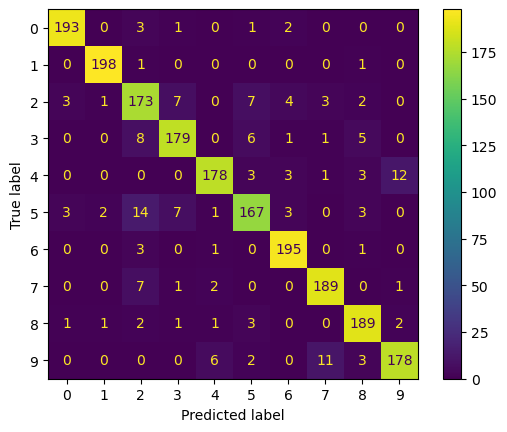

In [101]:
ConfusionMatrixDisplay.from_predictions(y_true=yframe.y,y_pred=yframe.yhat)

In [104]:
conf=confusion_matrix(y_true=yframe.y,y_pred=yframe.yhat)

In [126]:
for i in range(10):
    TP=conf[i,i]
    FP=conf[:,i].sum()-TP
    FN=conf[i].sum()-TP
    TN=conf.sum()-TP-FP-FN
    print(f'sencitivity of {i} = {TP/(TP+FN)}')
    print(f'specitifity of {i} = {TN/(TN+FP)}')

sencitivity of 0 = 0.965
specitifity of 0 = 0.9961111111111111
sencitivity of 1 = 0.99
specitifity of 1 = 0.9977777777777778
sencitivity of 2 = 0.865
specitifity of 2 = 0.9788888888888889
sencitivity of 3 = 0.895
specitifity of 3 = 0.9905555555555555
sencitivity of 4 = 0.89
specitifity of 4 = 0.9938888888888889
sencitivity of 5 = 0.835
specitifity of 5 = 0.9877777777777778
sencitivity of 6 = 0.975
specitifity of 6 = 0.9927777777777778
sencitivity of 7 = 0.945
specitifity of 7 = 0.9911111111111112
sencitivity of 8 = 0.945
specitifity of 8 = 0.99
sencitivity of 9 = 0.89
specitifity of 9 = 0.9916666666666667


## exercise 3
